In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

- [x] Предобработка данных
- [x] Анализ данных о регистрациях и займах
- [x] Сколько времени проходит с момента начала регистрации до оформления первого займа
- [x] Срок займа: план-факт + динамика
- [x] Категоризация займов по реальному сроку пользования деньгами
- [x] Исследование суммы займов
- [x] Когортный анализ:
    - [x] User Retention
    - [x] Ср.кол-во займов нарастающим итогом
    - [x] Ср.сумма займа нарастающим итогом
    - [x] ARPU
    - [x] Ретеншен капитала
    - [x] NPL

## Чтение данных и объединение таблиц с данными о регистрациях

In [2]:
# читаем данные
regs = pd.read_excel('regs.xlsx')
loans = pd.read_excel('loans.xlsx')

## Предобработка данных

### Регистрации

In [3]:
# посмотрим на общую информацию
regs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490428 entries, 0 to 490427
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   cid              490428 non-null  int64         
 1   uid              490428 non-null  object        
 2   ts               490428 non-null  datetime64[ns]
 3   is_reg_complete  490428 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 15.0+ MB


In [4]:
# изучим срез данных
regs.sample(5)

,cid,uid,ts,is_reg_complete
26751,1048792,5C63CE11-4388-4553-8097-4D35DDBFACD0,2019-04-15 21:59:47.533,0
284298,944310,79262958-FFA9-4DF9-95AC-2090F828C529,2019-02-08 10:21:51.533,1
289453,1421789,4EE56CAD-3975-47E1-B184-FABC723E9F9F,2020-09-23 17:58:04.876,1
65289,1326549,4A1CE0CE-8622-4C14-9262-3721EE839F08,2020-02-11 23:25:52.434,1
394785,1177031,D0E208D1-576C-4AE9-8C8F-F1991E0CCB37,2019-07-20 20:38:25.970,1


<b>cid</b> - id клиента<br>
<b>uid</b> - id юзера<br>
<b>ts</b> - время начала регистрации<br>
<b>is_reg_complete</b> - отметка о завершени регистрации<br>

In [5]:
# uid нам не потребуется в анализе, поэтому просто избавимся от лишней информации
regs.drop(columns=['uid'], inplace=True)

# также приведем к нужному формату данные в ts
regs['ts'] = regs['ts'].astype('datetime64[D]')

# переименуем также один столбец
regs.rename(columns={'ts': 'reg_ts'}, inplace=True)

# проверяем
regs.sample(5)

,cid,reg_ts,is_reg_complete
38414,1129802,2019-06-10,1
259571,1384382,2020-08-03,1
32640,1026044,2019-04-02,1
439370,1040511,2019-04-12,0
84738,1088489,2019-05-19,1


In [6]:
# проверим таблицу на наличие пропусков и дубликатов
display(regs.isna().sum())
display(regs.duplicated().sum())

cid                0
reg_ts             0
is_reg_complete    0
dtype: int64

0

<div class="alert alert-block alert-success">
<b>Вывод:</b> пропусков и дублей нет, двигаемся дальше
</div>

### Займы

In [7]:
# посмотрим на общую информацию
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94419 entries, 0 to 94418
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   cid       94419 non-null  int64         
 1   uid       94419 non-null  object        
 2   start_ts  86036 non-null  datetime64[ns]
 3   value     94419 non-null  float64       
 4   term      94419 non-null  int64         
 5   status    94419 non-null  object        
 6   end_ts    56292 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 5.0+ MB


In [8]:
# изучим срез данных
loans.sample(5)

,cid,uid,start_ts,value,term,status,end_ts
47796,1205314,02B2F1A0-E8FC-41F9-8AB7-05D44F4657FC,2019-09-12,33300.0,168,Просрочен,NaT
31588,1120504,08FBC297-28F1-49FC-BF03-28176D928E90,2019-06-10,2140.0,20,Погашен,2019-06-30 23:59:59.999
9784,933408,129D41E0-43BE-4391-B373-749E3D7EA5CC,2019-03-05,17000.0,30,На цессии,NaT
25671,1040451,5D98B738-4129-428C-A283-3F03B66D6BFF,2019-05-07,6500.0,30,Погашен,2019-06-20 23:59:59.999
18171,995090,AB715CC8-1E87-44BB-9A09-7F61E89BE384,2019-03-19,8000.0,27,На цессии,NaT


<b>cid</b> - id клиента<br>
<b>uid</b> - id юзера<br>
<b>start_ts</b> - время получения займа<br>
<b>value</b> - сумма<br>
<b>term</b> - срок<br>
<b>status</b> - статус на текущий момент<br>
<b>end_ts</b> - время возврата займа

In [9]:
# uid нам не потребуется в анализе, поэтому просто избавимся от лишней информации
loans.drop(columns=['uid'], inplace=True)

# также приведем к нужному формату данные в столбце end_ts
loans['end_ts'] = loans['end_ts'].astype('datetime64[D]')

# проверяем
loans.sample(5)

,cid,start_ts,value,term,status,end_ts
81715,1407874,2020-09-04,10000.0,10,Погашен,2020-09-10
54879,923581,2019-11-26,6000.0,30,На цессии,NaT
8765,927827,2019-01-30,2500.0,16,Погашен,2019-01-31
31165,1121065,2019-06-05,4576.0,30,Погашен,2019-06-21
13722,960546,2019-02-15,6100.0,23,Погашен,2019-03-01


In [10]:
# проверим таблицу на наличие пропусков и дубликатов
display(loans.isna().sum())
display(loans.duplicated().sum())

cid             0
start_ts     8383
value           0
term            0
status          0
end_ts      38127
dtype: int64

2135

<div class="alert alert-block alert-success">
<b>Вывод:</b> есть пропуски и дубликаты, обработаем их
</div>

In [11]:
# посмотим на стутусы займов с пропущенными значениями в столбце 'start_ts'
loans[loans['start_ts'].isna()]['status'].value_counts()

Отменён           8371
Не подтверждён      12
Name: status, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b> фактически эти статусы говорят о том, что клиент не получил деньги
</div>

In [12]:
# удалим эти строки
loans.dropna(subset=['start_ts'], inplace=True)

# проверяем
loans.isna().sum()

cid             0
start_ts        0
value           0
term            0
status          0
end_ts      29744
dtype: int64

In [13]:
# Посмотрим статусы займов, у которых отсутствуетм время погашения
loans[loans['end_ts'].isna()]['status'].value_counts()

На цессии              17111
Просрочен               8177
Активен                 2354
На реструктуризации     1727
Отменён                  311
Списан                    64
Name: status, dtype: int64

In [14]:
# посмотрим, остались ли дубликаты
loans.duplicated().sum()

0

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>дубли теперь отсутствуют
        <li>пропуски в end_ts фактически указывают на то, что заем не был закрыт на момент анализа данных
    </ul>
</div>
Теперь переходоим к анализу данных

## Аналитика данных

### 1. Анализ данных о регистрациях и займах. Динамика по времени, конверсия + графики

Нам нужна таблица, в которой будут данные в динамике по месяцам:
- Общее кол-во регистраций
- Кол-во успешных (завершенных) регистраций
- Общее кол-во займов
- Кол-во новых займов
- Кол-во повторных займов

#### 1.1 Групиировка данных о регистарциях

In [15]:
# добавим в таблицу regs столбцы: date, week, month - день, неделя и месяц регистрации
regs['reg_date'] = regs['reg_ts'].astype('datetime64[D]')
regs['reg_week'] = regs['reg_ts'].dt.to_period('W').apply(lambda r: r.start_time)
regs['reg_month'] = regs['reg_ts'].astype('datetime64[M]')

# проверяем
regs.head()

,cid,reg_ts,is_reg_complete,reg_date,reg_week,reg_month
0,1180314,2019-07-23,1,2019-07-23,2019-07-22,2019-07-01
1,1169902,2019-07-14,1,2019-07-14,2019-07-08,2019-07-01
2,939190,2019-02-06,1,2019-02-06,2019-02-04,2019-02-01
3,1135293,2019-06-14,1,2019-06-14,2019-06-10,2019-06-01
4,979757,2019-02-27,1,2019-02-27,2019-02-25,2019-02-01


In [16]:
# сгруппируем данные по месяцам, посчитаем общее кол-во регистраци и кол-во успешных регистраций
regs_by_month = regs.groupby(by='reg_month').agg({'cid': 'nunique', 'is_reg_complete': 'sum'})
regs_by_month.columns = ['total_regs', 'success_regs']

# смотрим
regs_by_month

,total_regs,success_regs
reg_month,,
2019-01-01,37669,31651
2019-02-01,45059,38293
2019-03-01,39752,33366
2019-04-01,41598,30584
2019-05-01,41689,30134
2019-06-01,33410,23810
2019-07-01,32892,24006
2019-08-01,10192,7860
2019-09-01,4843,3920


#### 1.2 Групиировка данных о займах

In [17]:
# у нас уже есть сгруппированные по месяцам данные о регистрациях, теперь тоже самое нужно сделать с займами
# но для начала - добавить в таблицу loans столбцы: date, week, month - день, неделя и месяц регистрации

loans['loan_date'] = loans['start_ts'].dt.date
loans['loan_week'] = loans['start_ts'].dt.to_period('W').apply(lambda r: r.start_time)
loans['loan_month'] = loans['start_ts'].astype('datetime64[M]')

# проверяем
loans.head()

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month
0,888862,2019-01-01,5000.0,30,Погашен,2019-01-02,2019-01-01,2018-12-31,2019-01-01
1,888862,2019-01-13,2500.0,7,Погашен,2019-01-13,2019-01-13,2019-01-07,2019-01-01
2,888862,2019-01-14,2500.0,30,Погашен,2019-01-31,2019-01-14,2019-01-14,2019-01-01
3,888862,2019-02-12,4700.0,30,Погашен,2019-02-15,2019-02-12,2019-02-11,2019-02-01
4,888862,2019-02-18,3000.0,30,Погашен,2019-02-21,2019-02-18,2019-02-18,2019-02-01


In [18]:
# для начала для каждого юзера найдем месяц первого займа
new_loans_by_month = loans.sort_values(by=['cid', 'start_ts']).groupby(by='cid').agg({'loan_month': 'first'}).reset_index()

# теперь сгруппируем данные по месяцам и подсчитаем кол-во уникальны займов
new_loans_by_month = new_loans_by_month.groupby(by='loan_month').agg({'cid': 'count'})
new_loans_by_month.columns = ['new_loans']

# проверяем
new_loans_by_month

,new_loans
loan_month,
2019-01-01,4540
2019-02-01,4969
2019-03-01,2976
2019-04-01,3043
2019-05-01,2480
2019-06-01,1391
2019-07-01,3209
2019-08-01,1852
2019-09-01,1345


In [19]:
# теперь посчитаем общее кол-во займов по месяцам
total_loans_by_month = loans.groupby(by='loan_month').agg({'cid': 'count'})
total_loans_by_month.columns = ['total_loans']

# проверяем
total_loans_by_month

,total_loans
loan_month,
2019-01-01,5434
2019-02-01,7152
2019-03-01,6199
2019-04-01,5814
2019-05-01,4955
2019-06-01,3251
2019-07-01,4777
2019-08-01,3477
2019-09-01,3016


In [20]:
# объеденим таблицы total_loans_by_month и new_loans_by_month
loans_by_month = pd.merge(total_loans_by_month, new_loans_by_month, on='loan_month')

# рассчитаем кол-во повторных займов
loans_by_month['repeated_loans'] = loans_by_month['total_loans'] - loans_by_month['new_loans']

# проверяем
loans_by_month

,total_loans,new_loans,repeated_loans
loan_month,,,
2019-01-01,5434,4540,894
2019-02-01,7152,4969,2183
2019-03-01,6199,2976,3223
2019-04-01,5814,3043,2771
2019-05-01,4955,2480,2475
2019-06-01,3251,1391,1860
2019-07-01,4777,3209,1568
2019-08-01,3477,1852,1625
2019-09-01,3016,1345,1671


#### 1.3 Объеденение данных в обну таблицу

In [21]:
total_grouped_data = pd.merge(regs_by_month, loans_by_month, left_index=True, right_index=True)

total_grouped_data

,total_regs,success_regs,total_loans,new_loans,repeated_loans
2019-01-01,37669,31651,5434,4540,894
2019-02-01,45059,38293,7152,4969,2183
2019-03-01,39752,33366,6199,2976,3223
2019-04-01,41598,30584,5814,3043,2771
2019-05-01,41689,30134,4955,2480,2475
2019-06-01,33410,23810,3251,1391,1860
2019-07-01,32892,24006,4777,3209,1568
2019-08-01,10192,7860,3477,1852,1625
2019-09-01,4843,3920,3016,1345,1671
2019-10-01,20404,16224,2316,1287,1029


#### 1.4 Графики

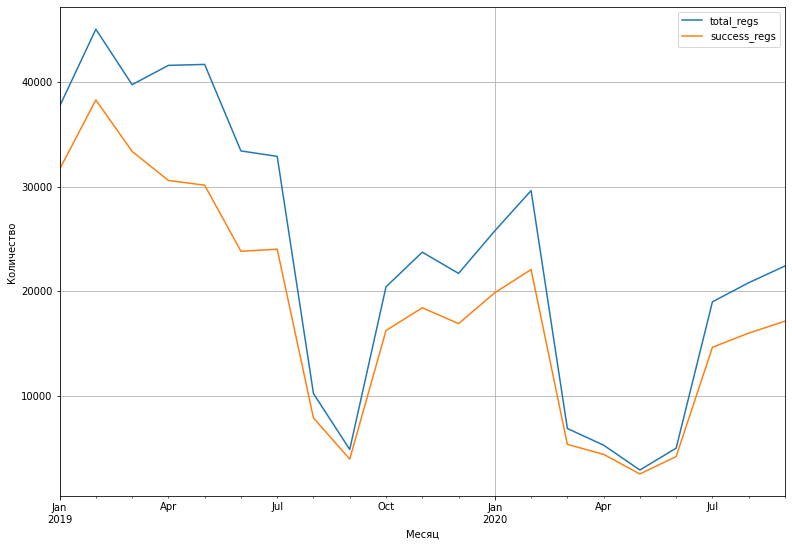

In [22]:
# построим график динамики регистраций по месяцам
total_grouped_data[['total_regs', 'success_regs']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

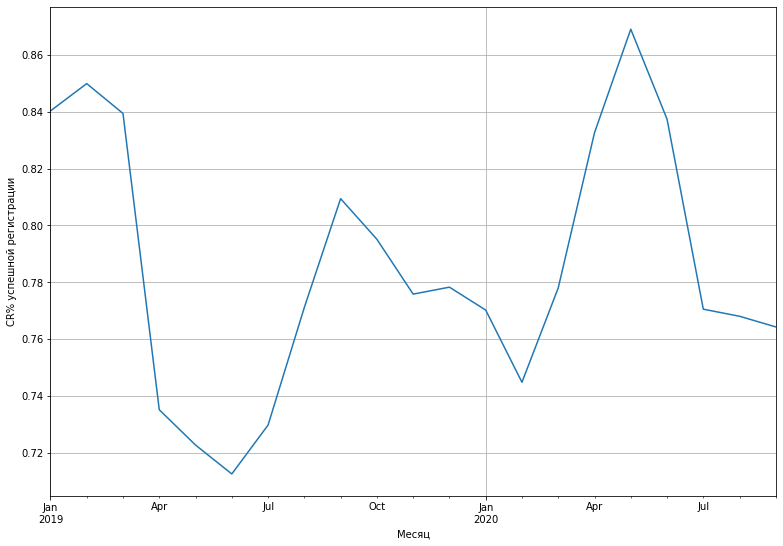

In [23]:
# а также ихучим конверсию из всех регистраций в успешные
(total_grouped_data['success_regs'] / total_grouped_data['total_regs']).plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('CR% успешной регистрации');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>количетсво регистраций (всех/успешных) стабильно сокращалось с апрелья 2019 года
        <li>при этом конверсия в успешную регистрацию за этот же период показала стабильный рост и достигла порядка 70%
    </ul>
</div>

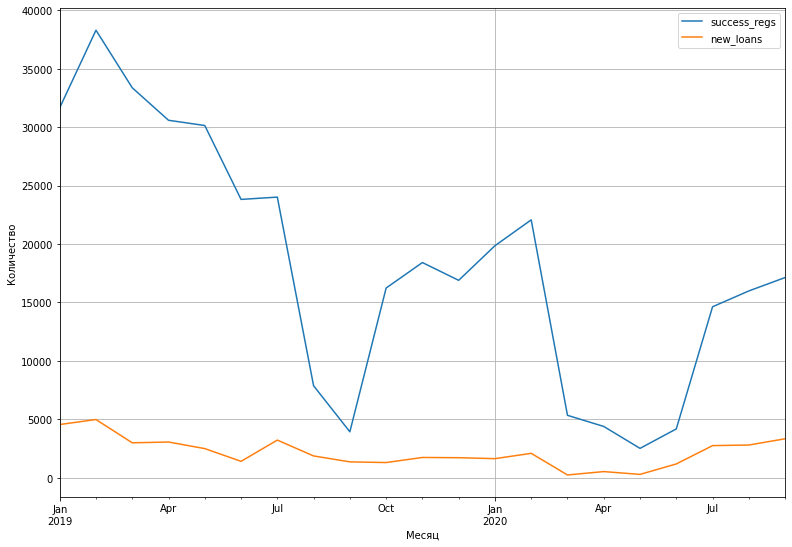

In [24]:
# теперь на одном графике сравним динамику успешных регистраций и новых займов
total_grouped_data[['success_regs', 'new_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество');

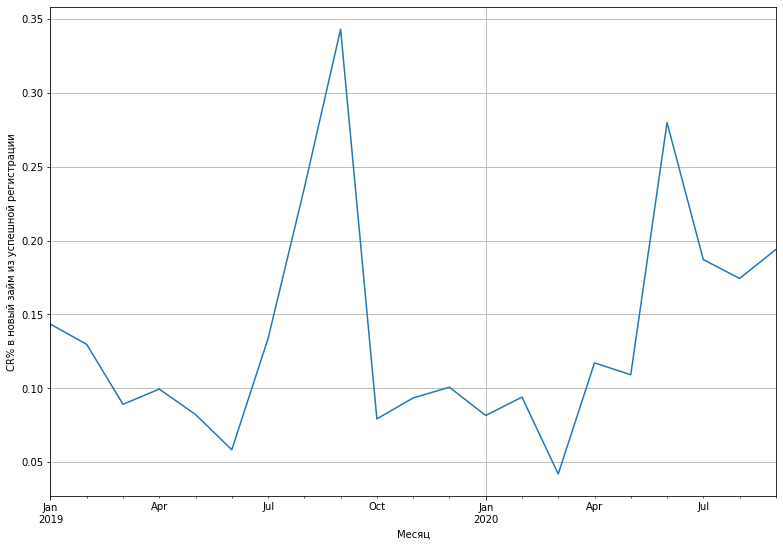

In [25]:
# а также посмотрим на конверсию в динамике
(total_grouped_data['new_loans'] / total_grouped_data['success_regs']).plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('CR% в новый займ из успешной регистрации');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>при стабильном сокращении успешных регистраций кол-во новых займов осталось практически на том же уровне
        <li>можно констатировать, что произошло это в первую очередь за счет роста конверсии в новый заем с 15% до 25%
        <li>однако это общие данные, которые состаят из различных источников трафика в тч высококонверсионной органики (в тч брендовой). Судя по данным из affise CPA канал в августе имел CR = 17%
    </ul>
</div>

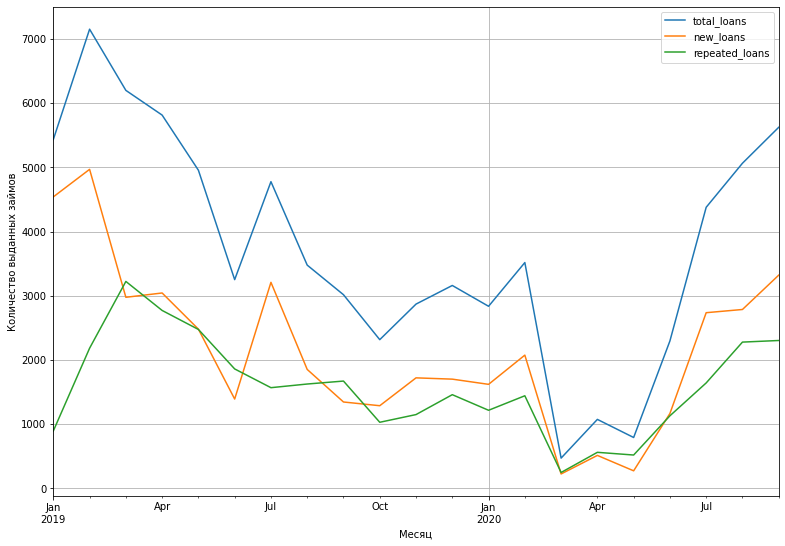

In [26]:
# посмотрим на долю потворных займов в динамике
total_grouped_data[['total_loans', 'new_loans', 'repeated_loans']].plot(figsize=(13, 9), grid=True);
plt.xlabel('Месяц');
plt.ylabel('Количество выданных займов');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>ближе к концу анализируемого периода наблюдается рост общего количества выданных займов
        <li>происходит это за счет роста повторных выдач. Это хороший для нас показатель
        <li>доля вопвторных займов колеблется в диапазоне 60%-70%
    </ul>
</div>

### 2. Сколько времени проходит с момента начала регистрации до оформления первого займа

In [27]:
# для начала из таблицы loans нам нужно получить для каждого юзера данные о его первом займе
first_loan_ts = loans.sort_values(by=['cid', 'start_ts']).groupby(by='cid').agg({'start_ts': 'first'}).reset_index()
first_loan_ts.columns=['cid', 'start_loan']

# проверяем
first_loan_ts.head()

,cid,start_loan
0,888862,2019-01-01
1,888868,2019-01-01
2,888872,2019-01-12
3,888882,2019-01-01
4,888884,2019-01-01


In [28]:
# теперь добавим эти данные в таблицу с регистрациями
time_to_loan = pd.merge(regs, first_loan_ts, how='left', on='cid')

# посмотрим на случайные 20 записей из получившейся таблицы
time_to_loan.sample(20)

,cid,reg_ts,is_reg_complete,reg_date,reg_week,reg_month,start_loan
193976,1361700,2020-06-22,1,2020-06-22,2020-06-22,2020-06-01,NaT
144927,1061126,2019-04-22,1,2019-04-22,2019-04-22,2019-04-01,NaT
410860,1401999,2020-08-28,1,2020-08-28,2020-08-24,2020-08-01,NaT
426937,1379086,2020-07-24,1,2020-07-24,2020-07-20,2020-07-01,NaT
97456,1102844,2019-05-24,1,2019-05-24,2019-05-20,2019-05-01,NaT
9606,936384,2019-02-04,1,2019-02-04,2019-02-04,2019-02-01,NaT
186793,1147862,2019-06-26,1,2019-06-26,2019-06-24,2019-06-01,NaT
305598,1181015,2019-07-23,1,2019-07-23,2019-07-22,2019-07-01,NaT
85871,957247,2019-02-13,1,2019-02-13,2019-02-11,2019-02-01,NaT
335142,1028730,2019-04-05,1,2019-04-05,2019-04-01,2019-04-01,NaT


<div class="alert alert-block alert-info">
<b>Важно:</b> во многих строках столбца start_loan появились значения NaT. Это говорит о том, что клиент начал регистрацию, но в итоге ни одного займа не получил. Избавимся от этих строк</div>

In [29]:
# удаляем лишние строки
time_to_loan.dropna(subset=['start_loan'], inplace=True)

In [30]:
# добавим в таблицу новый столбец с кол-во дней с начала регистрации до первого займа
time_to_loan['days_to_loan'] = (time_to_loan['start_loan'] - time_to_loan['reg_ts']).dt.days

time_to_loan.sample(10)

,cid,reg_ts,is_reg_complete,reg_date,reg_week,reg_month,start_loan,days_to_loan
69782,1258056,2019-12-03,1,2019-12-03,2019-12-02,2019-12-01,2019-12-03,0
287119,1099226,2019-05-23,1,2019-05-23,2019-05-20,2019-05-01,2020-11-11,538
317565,938735,2019-02-05,1,2019-02-05,2019-02-04,2019-02-01,2019-02-05,0
26293,1016832,2019-03-27,1,2019-03-27,2019-03-25,2019-03-01,2019-03-28,1
279875,944097,2019-02-08,1,2019-02-08,2019-02-04,2019-02-01,2019-04-24,75
256394,1331455,2020-02-16,1,2020-02-16,2020-02-10,2020-02-01,2020-02-16,0
82462,893882,2019-01-07,1,2019-01-07,2019-01-07,2019-01-01,2019-01-07,0
105481,1372308,2020-07-14,1,2020-07-14,2020-07-13,2020-07-01,2020-07-15,1
251109,1415860,2020-09-15,1,2020-09-15,2020-09-14,2020-09-01,2020-09-15,0
317038,1309432,2020-01-31,1,2020-01-31,2020-01-27,2020-01-01,2020-01-31,0


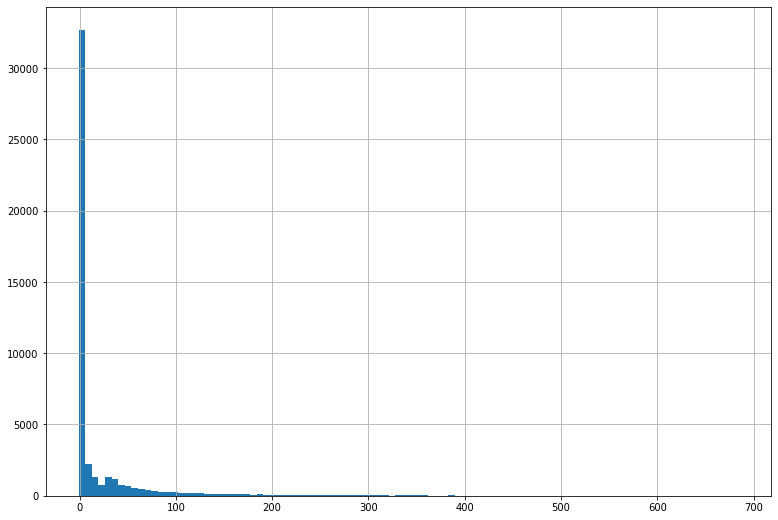

In [31]:
# построим гистограмму
time_to_loan['days_to_loan'].hist(figsize=(13, 9), bins=100);

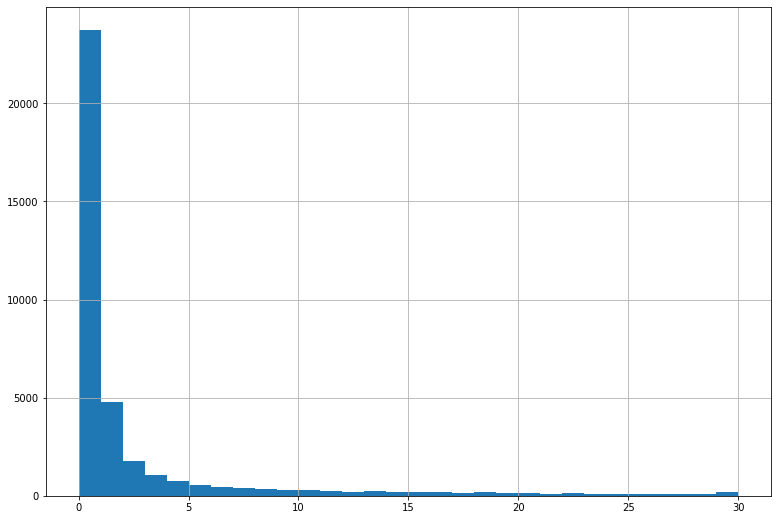

In [32]:
# львиная доля значений лежит в диапазоне от 0 до 30 дней, ограничим гистограмму этими значениями
time_to_loan['days_to_loan'].hist(figsize=(13, 9), bins=30, range=(0, 30));

In [33]:
# посмотрим на ТОП10 значений
time_to_loan['days_to_loan'].value_counts().head(10)

0     23740
1      4796
2      1793
3      1053
4       732
5       554
6       444
7       375
31      366
8       340
Name: days_to_loan, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>львиная доля клиентов получают свой первый заем в день регистрации
        <li>кол-во выдач на следующий день относительно большое, но это в т.ч. может быть связано с займами, которые оформляются в вечернее время и выдаются уже на следующий день
        <li>есть небольшой скачок на 32 день. Скорее всего это связано с разблокировкой спустя 30 дней
        <li>чем дальше от времени регистрации тем меньше шанс, что клиент оформит свой первый заем
        <li>в качестве рекомендации - нужно стараться максимально быстро конвертировать регистрацию в первый заем
    </ul>
</div>

### 3. Исследвание срока займа (план, факт) + динамика по месяцам

#### 3.1 Запрашиваемые и фактические значения займов

In [34]:
# рассчитаем фактический срок пользования деньгами
loans['real_term'] = (loans['end_ts'] - loans['start_ts']).dt.days

# удалим пустые значения т.к. нам нужны только те займы, которые уже погашены и сохраним данные в отдельный датафрейм
real_term = loans.query('real_term.notna()')
real_term['real_term'] = real_term['real_term'].astype('int')

# проверим на выборке
real_term.sample(10)

,cid,start_ts,value,term,status,end_ts,loan_date,loan_week,loan_month,real_term
21386,1042661,2019-04-13,14000.0,30,Погашен,2019-05-13,2019-04-13,2019-04-08,2019-04-01,30
64543,1169973,2020-02-22,9800.0,25,Погашен,2020-03-10,2020-02-22,2020-02-17,2020-02-01,17
31795,894944,2019-06-09,10700.0,30,Погашен,2019-06-28,2019-06-09,2019-06-03,2019-06-01,19
32647,982087,2019-06-15,6955.0,30,Погашен,2019-06-21,2019-06-15,2019-06-10,2019-06-01,6
24297,1027554,2019-04-26,3500.0,20,Погашен,2019-05-17,2019-04-26,2019-04-22,2019-04-01,21
8294,925329,2019-02-05,20000.0,25,Погашен,2019-03-02,2019-02-05,2019-02-04,2019-02-01,25
11283,942285,2019-02-07,17000.0,30,Погашен,2019-03-21,2019-02-07,2019-02-04,2019-02-01,42
75075,1380568,2020-07-27,3600.0,32,Погашен,2020-08-13,2020-07-27,2020-07-27,2020-07-01,17
85525,1420003,2020-09-25,3000.0,30,Погашен,2020-10-10,2020-09-25,2020-09-21,2020-09-01,15
26235,1029190,2019-05-11,16907.0,30,Погашен,2019-09-05,2019-05-11,2019-05-06,2019-05-01,117


In [35]:
# сравним сумму дней из запросов пользователей с суммой фактических дней пользования кредитом
print(f'Всего займов было оформлено на {real_term["term"].sum():,} дня(ей)')
print(f'Фактически с учетом досрочных погашений и просрочек деньгами пользовались {real_term["real_term"].sum():,} дня(ей)')

Всего займов было оформлено на 1,617,551 дня(ей)
Фактически с учетом досрочных погашений и просрочек деньгами пользовались 2,009,135 дня(ей)


<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li> Суммарный фактичесий срок пользования деньгами на 10,5% (или 862,699 дней) больше, чем все суммарные запрошенные значения. Это даже с учетом займов, которые погашаются досрочно (спойлер: их достаточно много)
    </ul>
</div>

count    56292.000000
mean        28.735007
std         14.201437
min          1.000000
25%         20.000000
50%         30.000000
75%         35.000000
max        168.000000
Name: term, dtype: float64

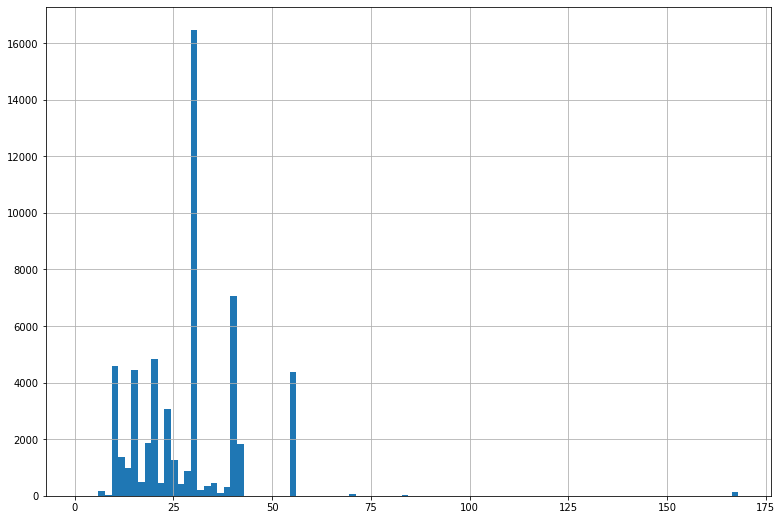

In [36]:
# распределение запрашиваемых сроков займов
display(real_term['term'].describe())
real_term['term'].hist(bins=100, figsize=(13, 9));

#### 3.2 Распределение показателей, среднее значение, медиана, мода

count    56292.000000
mean        35.691306
std         40.965767
min          0.000000
25%         10.000000
50%         24.000000
75%         45.000000
max        656.000000
Name: real_term, dtype: float64

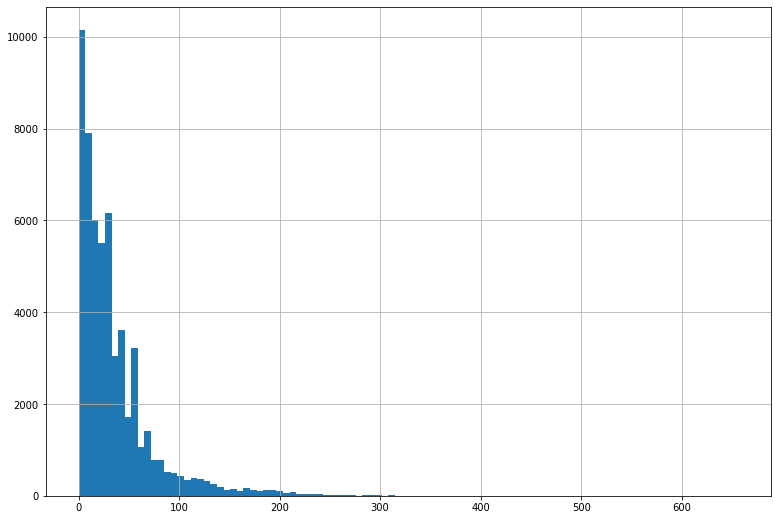

In [37]:
# распределение фактических сроков пользования займом
display(real_term['real_term'].describe())
real_term['real_term'].hist(bins=100, figsize=(13, 9));

In [38]:
# ТОП5 запрашиваемых сроков
real_term['term'].value_counts().head()

30    15909
40     7048
56     4386
10     4226
20     3993
Name: term, dtype: int64

In [39]:
# ТОП5 фактических сроков
real_term['real_term'].value_counts().head()

30    1850
1     1845
0     1821
56    1743
10    1498
Name: real_term, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>графики распределения отличаются очень сильно. Это говорит о том, что то, как люди планируют возвращать деньги и то, как они их возвращают - это разные значения
        <li>также на распределение оказывает влияение то, что запрашиваемый срок займа строго ограничен
        <li>среднее значение фактического пользования займом = 32.66 дня, средний запрашиваемый срок = 29.55 дня
        <li>медианное значение больше уже у запрашиваемых показателй - 30 дней против 20 дней. Т.е. 50% займов закрываются в срок до 20 дней
        <li>в ТОП5 значений фактического пользования займами есть 2 не очень хороших значения - это 0 день (погашение в день получения займа) и 1 (погашение на следующий день)
        <li>25% займов погашаются до 8 дней, 50% до 20 дней, 75% до 42 дней. Над этими показателями стоило бы поработать
    </ul>
</div>

#### 3.3 Динамка планового и фактического срока пользования деньгами

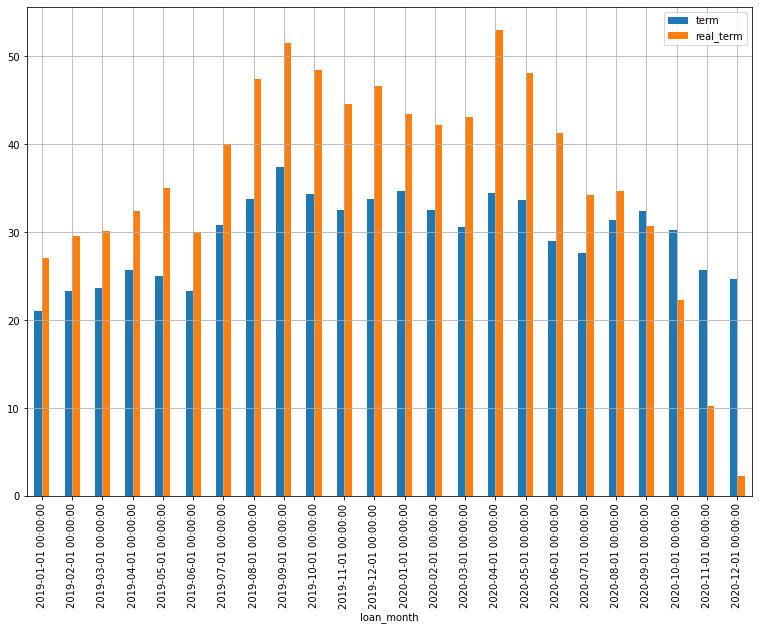

In [40]:
real_term.groupby('loan_month').agg({'term': 'mean', 'real_term': 'mean'}).plot(kind='bar', figsize=(13, 9), grid=True);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>весь 2019 год средний срок пользовния деньгами показывал положительную динамику
        <li>в этот же период мы видим значительно большой рост факт.пользования отностилеьно плана
        <li>начиная с июля график идет вниз, но это скорее всего связано с тем, что часть клиентов из просрочки еще не вернули деньги (но согласно статистике обязательно вернут) либо доля досрочных погашений выросла
        <li>в дальнейшем посомотрим еще на эти показатели в когортах
    </ul>
</div>

### 4. Категоризация займов по реальному сроку пользования деньгами

In [41]:
# созданим функцию категоризации срока закрытия займа
def set_term_category(row):
    if row['real_term'] == row['term']:
        return 'В срок'
    elif row['real_term'] < row['term']:
        return 'Досрочно'
    elif row['real_term'] > row['term']:
        return 'С просрочкой'
    return 'Не закрыт'

In [ ]:
# применяем функцию
loans['term_category'] = loans.apply(set_term_category, axis=1)

# проверяем
loans.sample(10)

In [ ]:
# построим круговую диаграмму для визуализации разделения займов по типам погашения
loans.groupby('term_category').agg({'cid': 'count'}).plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%');

In [ ]:
# та же диаграмма, но без статуса "Не закрыт"
loans.query('term_category != "Не закрыт"')\
.groupby('term_category').agg({'cid': 'count'}).plot(kind='pie', subplots=True, figsize=(10, 10), autopct='%1.1f%%');

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>27.4% не закрытых займов - цифра немного преувеличенная т.к. чем ближе анализируемый месяц к текущему - тем больше % невозвратов и наоборот.
        <li>Если анализировать уже закрытые займы - 55.6% досрочно закрытых займов это большая цифра. И это как раз точка роста
    </ul>
</div>

### 4. Исследование суммы займов

#### 4.1 Базовые данные о сумме займов

In [ ]:
print(f'Суммарные выдачи за анализируемый период составили {loans["value"].sum():,} рублей')

In [ ]:
# посмотрим на среднее, медиану, квартили и другие значения
loans['value'].describe()

In [ ]:
# TOP10 частотность
loans['value'].value_counts().head(10)

In [ ]:
# посмотрим на распределение
loans['value'].hist(figsize=(13, 9), bins=80);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>общая сумма выданных средств за анализируемый период 3 683 503 741 рубля
        <li>средняя выдача - 9648 рублей
        <li>первый-третий квартили: 4500, 8000, 12000. Это значит, что 25% займов оформляются на сумму, меньше 4500р, 50% займов на сумму до 8000 и 75% займов на сумму до 12000 рублей.
        <li>чаще всего берут займ на 8000 рублей (28526 раз)
        <li>в ТОП10 значений по частоте 7 значений меньше 10000 рублей
    </ul>
</div>

#### 4.2 Динамика измениня средней суммы займа

In [ ]:
# группируем данные по месяцам, для каждого месяца считаем суммарный объем займов и количество займов
avg_loan_value = loans.groupby('loan_month').agg({'value': 'sum', 'cid': 'count'})

# переименуюем столбцы
avg_loan_value.columns=['total_value', 'total_loans']

# посчитаем средний чек
avg_loan_value['avg_loan_value'] = (avg_loan_value['total_value'] / avg_loan_value['total_loans']).astype('int')

avg_loan_value

In [ ]:
# посмотрим на чек в динамике
avg_loan_value['avg_loan_value'].plot(figsize=(13, 9), grid=True);

In [ ]:
print(f'Минимальное занчение {avg_loan_value["avg_loan_value"].min()} рубл.')
print(f'Максимальное занчение {avg_loan_value["avg_loan_value"].max()} руб.')

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>мин-макс средние значения находятся в диапазоне от 8154 руб до 10672 руб
        <li>не прослеживается какой-либо тренд на рост-падение, есть только периодические колебания на 10-20%
    </ul>
</div>

### 5. Когортный анализ

#### 5.1 Ретеншен

In [ ]:
# для начала нам нужно выделить в отдельную таблицу месяц первого займа для каждого пользователя
loan_first_month = loans.sort_values(by=['cid', 'loan_month']).groupby(by='cid').agg({'loan_month': 'first'}).reset_index()

# переименуем столбцы
loan_first_month.columns = ['cid', 'loan_first_month']

# смотрим на результат
loan_first_month

In [ ]:
# объеденим таблицы loans vs loan_first_month
loans = pd.merge(loans, loan_first_month, on='cid')

# добавим в таблицу столбец cohort_lifetime, который указывает на срок жизни когорты в месяцах
loans['cohort_lifetime'] =((loans['loan_month'] - loans['loan_first_month']) / np.timedelta64(1,'M'))\
.round().astype('int')

# смотрим на результат
loans.head()

In [ ]:
# создадим новую таблицу retention и сгруппируем в нее данные из таблицы loans
retention = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'nunique'}).reset_index()

# переименуем колонки
retention.columns = ['loan_first_month', 'cohort_lifetime', 'active_users']

# смотрим результат
retention

In [ ]:
# теперь в отдельной таблице сохраним пользователей нулевой когорты
initial_users = retention[retention['cohort_lifetime'] == 0][['loan_first_month', 'active_users']]

# переименуем столбцы
initial_users.columns = ['loan_first_month', 'initial_users']

# смотрим результат
initial_users

In [ ]:
# добавим в таблицу retention столбец initial_users из таблицы initial_users
retention = pd.merge(retention, initial_users, on='loan_first_month')

# рассчитаем retention_rate
retention['retention_rate'] = retention['active_users'] / retention['initial_users']

# смотрим финальную таблицу
retention.head()

In [ ]:
# группируем все в сводную таблицу
retention_pivot = retention.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                                        values='retention_rate', aggfunc='sum')

In [ ]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmax=0.4, vmin=0.025);

<div class="alert alert-block alert-success">
<b>Вывод:</b>
    <ul>
        <li>в начале и середине 2019 года мы видим достаточно хороший ретеншен в месяцах 0-1-2
        <li>затем, примерно в авгуте 2019 показатели стали ухудшаться и ретеншен 1 месяца опустился до 20%, а затем и вовсе до 15%
        <li>однако сейчас снова наблюдается рост, начиная с мая 2020
    </ul>
</div>

#### 5.2 Среднее кол-во займов

In [ ]:
avg_loan_amount = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'count'}).reset_index()
avg_loan_amount.rename(columns={'cid': 'cumsum_loans'}, inplace=True)
avg_loan_amount = pd.merge(avg_loan_amount, initial_users, on='loan_first_month')
avg_loan_amount['avg_loans'] = (avg_loan_amount['cumsum_loans'] / avg_loan_amount['initial_users']).round(2)

avg_loan_amount.head()

In [ ]:
avg_loan_pivot = avg_loan_amount.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='avg_loans', aggfunc='mean').cumsum(axis=1)

In [ ]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Avg. Loans Cumsum')
sns.heatmap(avg_loan_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=0.6, vmax=2.6);

#### 5.3 ARPU (Average Revenue per User)

In [ ]:
arpu = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum'}).reset_index()
arpu = pd.merge(arpu, initial_users, on='loan_first_month')
arpu['arpu'] = ((arpu['value'] / arpu['initial_users'])/1000).round(2)

arpu.head()

In [ ]:
arpu_pivot = arpu.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='arpu', aggfunc='mean').cumsum(axis=1)

In [ ]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: ARPU')
sns.heatmap(arpu_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm');

#### 5.4 Средняя сумма займа в конкретный месяц
почему с ростом lifetime "чек" не растет?

In [ ]:
avg_loan_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', 'cid': 'count'}).reset_index()
avg_loan_value['avg_loan_value'] = ((avg_loan_value['value'] / avg_loan_value['cid'])/1000).round(2)

avg_loan_value.head()

In [ ]:
avg_loan_value_pivot = avg_loan_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='avg_loan_value', aggfunc='mean')

In [ ]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Loan Value')
sns.heatmap(avg_loan_value_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=9, vmax=11.5);

#### 5.4 Средняя сумма займа накопительным итогом

In [ ]:
avg_cumsum_loan_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', 'cid': 'count'})\
.groupby(level=0).cumsum().reset_index()
avg_cumsum_loan_value.rename(columns={'value': 'cumsum_value', 'cid': 'cumsum_loans'}, inplace=True)
avg_cumsum_loan_value['avg_cumsum_loan_value'] = ((avg_cumsum_loan_value['cumsum_value'] / avg_cumsum_loan_value['cumsum_loans'])/1000).round(2)

avg_cumsum_loan_value.head()

In [ ]:
avg_cumsum_loan_pivot = avg_cumsum_loan_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                              values='avg_cumsum_loan_value', aggfunc='mean')

In [ ]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: Loan Value')
sns.heatmap(avg_cumsum_loan_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=9, vmax=10.1);

#### 5.5 Оборотка нарастающим итогом

In [ ]:
cumsum_value = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'value': 'sum', }).reset_index()
cumsum_value['value'] = (cumsum_value['value'] / 10000000).round(2)

cumsum_value

In [ ]:
initial_value = cumsum_value[cumsum_value['cohort_lifetime'] == 0][['loan_first_month', 'value']]
initial_value.columns=['loan_first_month', 'initial_value']
initial_value

In [ ]:
cumsum_value = pd.merge(cumsum_value, initial_value, on='loan_first_month')
cumsum_value['value_gain'] = cumsum_value['value'] / cumsum_value['initial_value']

cumsum_value.head(20)

In [ ]:
cumsum_value_pivot = cumsum_value.pivot_table(index='loan_first_month', columns='cohort_lifetime', 
                         values='value_gain', aggfunc='mean').cumsum(axis=1)

In [ ]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: User Retention')
sns.heatmap(cumsum_value_pivot, annot=True, fmt='.3', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmax=2.5);

In [ ]:
loans['end_month'] = loans['end_ts'].astype('datetime64[M]')
loans.head()

In [ ]:
get_loans = loans.groupby(['loan_first_month', 'cohort_lifetime']).agg({'cid': 'count'}).groupby(level=0).cumsum().reset_index()
get_loans.rename(columns={'cid': 'get_loans'}, inplace=True)
get_loans.head()

In [ ]:
paid_loans = loans.groupby(['loan_first_month', 'end_month']).agg({'cid': 'count'}).groupby(level=0).cumsum().reset_index()
paid_loans['cohort_lifetime'] = ((paid_loans['end_month'] - paid_loans['loan_first_month']) / np.timedelta64(1,'M')).round().astype('int')
paid_loans.drop(columns='end_month', inplace=True)
paid_loans = paid_loans[['loan_first_month', 'cohort_lifetime', 'cid']]
paid_loans.rename(columns={'cid': 'paid_loans'}, inplace=True)

paid_loans.head()

In [ ]:
output = pd.merge(get_loans, paid_loans, on=['loan_first_month', 'cohort_lifetime'])
output['r_rate'] = output['paid_loans'] / output['get_loans']
output_pivot = output.pivot_table(index='loan_first_month', columns='cohort_lifetime', values='r_rate')

In [ ]:
# Наведем немного крастоты
plt.figure(figsize=(26, 18))
plt.title('Cohorts: NPL')
sns.heatmap(output_pivot, annot=True, fmt='.1%', linewidths=1, 
            linecolor='grey', cmap='coolwarm', vmin=0.4, vmax=0.78);